# Proyek Pertama : Membuat Model NLP dengan TensorFlow

---



Nama: Kemal Adam Roisy

Email: kemal.adam@sci.ui.ac.id

Kelas: Belajar Pengembangan Machine Learning


## Kriteria Submission



1.   Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.
2.   Harus menggunakan LSTM dalam arsitektur model.
3.   Harus menggunakan model sequential.
4.   Validation set sebesar 20% dari total dataset.
5.   Harus menggunakan Embedding.
6.   Harus menggunakan fungsi tokenizer.
7.   Akurasi dari model minimal 75%.

# Import Data dari kaggle

Data Source: Kaggle BBC articles fulltext and category

url: https://www.kaggle.com/yufengdev/bbc-fulltext-and-category

In [1]:
# Install kaggle package to use API
!pip install -q kaggle

In [2]:
# Upload kaggle.json API Token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kemaladamr","key":"315f8636beaccfe56af5b9fe74bdbfb2"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d yufengdev/bbc-fulltext-and-category

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 60.5MB/s]


In [5]:
!mkdir bbc
!unzip bbc-fulltext-and-category.zip -d bbc
!ls bbc

Archive:  bbc-fulltext-and-category.zip
  inflating: bbc/bbc-text.csv        
bbc-text.csv


# Import library dan depedencies

In [1]:
import pandas as pd
import re
# import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop

# Data Import dan Preprocessing

In [2]:
df = pd.read_csv('bbc/bbc-text.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [3]:
print("Total data yang kosong\n{}\n".format(df.isnull().sum()))
print("Total duplikat data {}".format(df.duplicated().sum()))

Total data yang kosong
category    0
text        0
dtype: int64

Total duplikat data 99


In [4]:
# df = df.dropna()
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.category.value_counts()

sport            504
business         503
politics         403
entertainment    369
tech             347
Name: category, dtype: int64

In [5]:
target = list(df.category.unique())

## Text Cleanseing

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')


df.text = df.text.apply(lambda x: x.lower())

signs = list(punctuation) # special characters 
stop_word = list(stopwords.words('english')) # stop words like `a,an,the,or,at` etc
wordnet_lemmatizer = WordNetLemmatizer() # make the word cooking,cooks,cooked -> cook (in ideal case)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
def clean_articles(df):

    #REPLACING    
    df['text'] = df['text'].str.replace("\r", " ")
    df['text'] = df['text'].str.replace("\n", " ")
    df['text'] = df['text'].str.replace("    ", " ")
    df['text'] = df['text'].str.replace('"', '')
    df['text'] = df['text'].str.lower()  
    for sign in signs:
        df['text'] = df['text'].str.replace(sign, '')
    df['text'] = df['text'].str.replace("'s", "")

    #LEMMATIZER
    nrows = len(df)
    lemmatized_text_list = []
    for row in range(nrows):
        lemmatized_list = [] 
        text = df.loc[row]['text'] 
        text_words = text.split(" ")
        for word in text_words:  
            lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        lemmatized_text = " ".join(lemmatized_list)  
        lemmatized_text_list.append(lemmatized_text) 
    df['text'] = lemmatized_text_list
    
    #REMOVING STOPWORDS
    for sw in stop_word:
        re_sw = r"\b" + sw + r"\b"
        df['text'] = df['text'].str.replace(re_sw, '')

In [8]:
clean_articles(df)

## Word count distribution

In [9]:
df['num_words'] = df['text'].apply(lambda x:len(str(x).split()))

Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

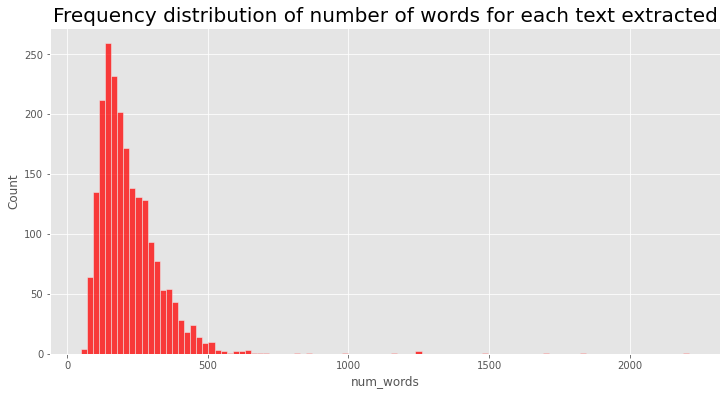

In [10]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.histplot(df['num_words'],kde = False,color="red",bins=100)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

## One hot encoding

In [11]:
kategori = pd.get_dummies(df.category)
new_df = pd.concat([df, kategori], axis=1)
new_df.drop(columns=['category', 'num_words'], inplace=True)
new_df.head()

,text,business,entertainment,politics,sport,tech
0,tv future hand viewers home theatre system...,0,0,0,0,1
1,worldcom boss leave book alone former worldc...,1,0,0,0,0
2,tigers wary farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle fa cup premiership sid...,0,0,0,1,0
4,ocean twelve raid box office ocean twelve ...,0,1,0,0,0


# Splitting Data for Training & Testing

In [12]:
text = new_df['text'].values
label = new_df[target].values

In [13]:
# Split data untuk training dan test
text_train, text_test, label_train, label_test = train_test_split(
                text, label, test_size=0.2,
                random_state=42
                )

In [14]:
print("Jumlah data training: {} (80%)\n".format(len(label_train)))
print("Jumlah data testing: {} (20%)\n".format(len(label_test)))

Jumlah data training: 1700 (80%)

Jumlah data testing: 426 (20%)



# Tokenisasi

In [15]:
# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token='x')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)

# Sekuens
sekuens_train = tokenizer.texts_to_sequences(text_train)
sekuens_test = tokenizer.texts_to_sequences(text_test)

# Padding
padded_train = pad_sequences(sekuens_train)
padded_test = pad_sequences(sekuens_test)


Callbacks

In [16]:
# # callback
# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
#       self.model.stop_training = True
#       print("\nThe accuracy of the training set and the validation set has reached > 90%!")
# callbacks = myCallback()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=1.5e-5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

# Model Sequential

In [17]:
# Model

# model = tf.keras.Sequential([
#             tf.keras.layers.Embedding(input_dim=20000, output_dim=64),
#             tf.keras.layers.Dropout(0.5),
#             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#             tf.keras.layers.Dense(64,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
#                                   bias_regularizer=regularizers.l2(1e-4),
#                                   activity_regularizer=regularizers.l2(1e-5), activation='relu'),
#             tf.keras.layers.Dropout(0.3),
#             tf.keras.layers.Dense(5, activation='softmax')
# ])

model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=20000, output_dim=64),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(5, activation='softmax')
])

In [18]:
model.compile(loss='categorical_crossentropy',
            #   optimizer='adam',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1280000   
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 1,321,989
Trainable params: 1,321,989
Non-trainable params: 0
______________________________________________

# Model Fitting

In [19]:
# model fit
history = model.fit(padded_train,
                    label_train, 
                    epochs=20,
                    validation_data=(padded_test, label_test),
                    verbose=1,
                    callbacks=[reduce_lr, early_stop],
                    # batch_size=64
                    )

Epoch 1/20
54/54 [==============================] - 8s 95ms/step - loss: 1.5534 - accuracy: 0.2994 - val_loss: 1.2398 - val_accuracy: 0.4390
Epoch 2/20
54/54 [==============================] - 5s 85ms/step - loss: 1.1036 - accuracy: 0.4629 - val_loss: 0.9853 - val_accuracy: 0.5892
Epoch 3/20
54/54 [==============================] - 5s 86ms/step - loss: 0.7805 - accuracy: 0.6494 - val_loss: 0.7180 - val_accuracy: 0.7113
Epoch 4/20
54/54 [==============================] - 5s 86ms/step - loss: 0.5045 - accuracy: 0.8435 - val_loss: 0.3742 - val_accuracy: 0.9061
Epoch 5/20
54/54 [==============================] - 5s 87ms/step - loss: 0.4241 - accuracy: 0.9024 - val_loss: 0.6279 - val_accuracy: 0.8474
Epoch 6/20
54/54 [==============================] - 5s 87ms/step - loss: 0.1444 - accuracy: 0.9629 - val_loss: 0.7207 - val_accuracy: 0.7653
Epoch 7/20
54/54 [==============================] - 5s 88ms/step - loss: 0.1224 - accuracy: 0.9765 - val_loss: 0.2643 - val_accuracy: 0.9202
Epoch 8/20
54

# Plotting Accuracy dan Loss

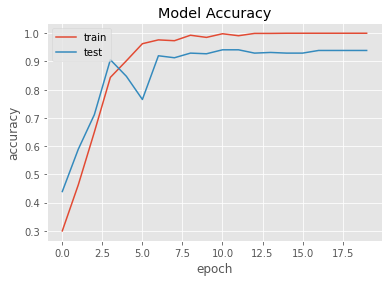

In [20]:
# plot of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

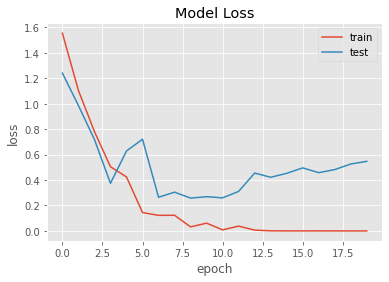

In [21]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()